In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import random
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator,img_to_array,load_img
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import cv2
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,RMSprop
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [3]:
train_path = "/content/drive/MyDrive/train"
val_path = "/content/drive/MyDrive/val"
test_path = "/content/drive/MyDrive/test"
batch_size = 16
img_height = 500
img_width = 500

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 500
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train1 = get_training_data('/content/drive/MyDrive/train')
test2 = get_training_data('../content/drive/MyDrive/val')
val3 = get_training_data('../content/drive/MyDrive/test')

<ipython-input-4-976af2ba015b>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
DATASET_PATH = train_path
dir_list = os.listdir(DATASET_PATH)
print(dir_list)

['NORMAL', 'PNEUMONIA']


In [ ]:
# num_of_images = []
# for root, dirs, files in os.walk(DATASET_PATH):
#     if root == DATASET_PATH: continue
#     print('{}: {}'.format(os.path.filesbasename(root), len(files)))
#     num_of_images.append(len())

In [ ]:
# normal_case_dir=str(dir_list) + 'NORMAL'
# pneumonia_case_dir=str(dir_list) + 'PNEUMONIA'
# normal_cases=os.listdir(DATASET_PATH)
# pneumonia_cases=os.listdir(DATASET_PATH)

# train_data=[]

# #All the normal_cases images in label 0
# for img in normal_case_dir:
#     train_data.append((img,0))
   
  
# # All the pneumonia cases images in label 1
# for img in pneumonia_cases:
#     train_data.append((img,1))

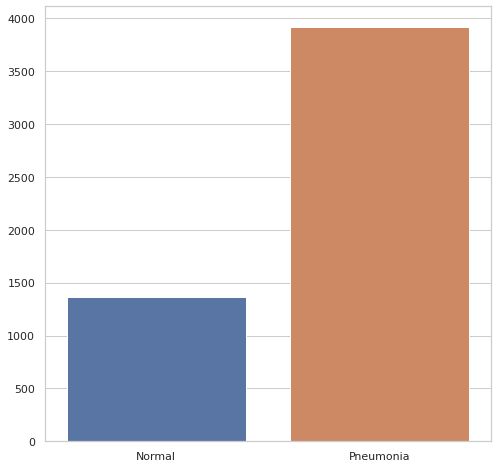

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (8,8))
ax = sns.barplot( x = ["Normal", "Pneumonia"], y = num_of_images)

### Data Augmentation
In order to expand and improve the classification model, the data has been modified. 
The size has been changed to 500 * 500. It was turned over and given a horizontal flip so that the program could perform Recognitional. Also, data has been Rescale the original image's scales array so that the pixels' values fall between [0,1] and has been zoom.


In [4]:
train_val_generator = ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.3)
test_generator = ImageDataGenerator(rescale=1./255)

In [5]:
train = train_val_generator.flow_from_directory(train_path,
                                               batch_size=batch_size,
                                               target_size=(img_height,img_width),
                                               color_mode="grayscale",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")



Found 5277 images belonging to 2 classes.


In [6]:
val = train_val_generator.flow_from_directory(val_path,
                                               batch_size=batch_size,
                                               target_size=(img_height,img_width),
                                               color_mode="grayscale",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 16 images belonging to 2 classes.


In [7]:
test = test_generator.flow_from_directory(test_path,
                                          batch_size=batch_size,
                                          target_size=(img_height,img_width),
                                          color_mode="grayscale",
                                          class_mode="binary")

Found 624 images belonging to 2 classes.


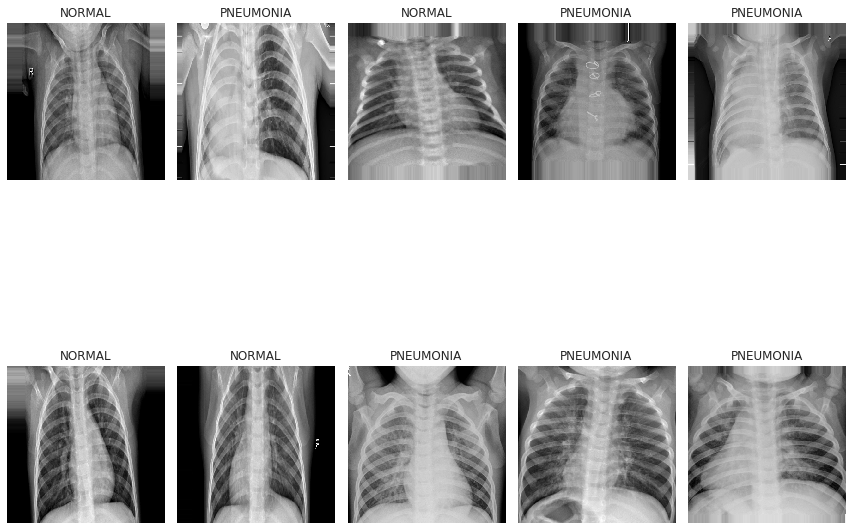

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

## #Bulid model, activation, loss function and optimizer

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization 
from tensorflow.keras.layers import Conv2D, MaxPool2D 
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import GridSearchCV

In [9]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu",strides=1,padding='same', input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu",strides=(2,2),padding='same', input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu",strides=1,padding='same', input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu",strides=(2,2),padding='same', input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu",strides=1,padding='same', input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))


cnn.add(Conv2D(64, (3, 3), activation="relu",strides=(2,2),padding='same' ,input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())
cnn.add(Dense(128,activation = 'relu'))
cnn.add(Dense(64,activation = 'relu'))
# cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.add(Dense(1, activation = 'sigmoid'))


   

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 500, 500, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 250, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0

In [11]:
cnn.compile(optimizer= Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics = ["accuracy"])
  

In [ ]:
history = cnn.fit(train,epochs=10, validation_data=val,verbose=1)

Epoch 1/10
330/330 [==============================] - 1003s 3s/step - loss: 0.4751 - accuracy: 0.7806 - val_loss: 2.4400 - val_accuracy: 0.5625
Epoch 2/10
330/330 [==============================] - 994s 3s/step - loss: 0.2754 - accuracy: 0.8819 - val_loss: 0.8851 - val_accuracy: 0.6875
Epoch 3/10
330/330 [==============================] - 992s 3s/step - loss: 0.2324 - accuracy: 0.9090 - val_loss: 1.2072 - val_accuracy: 0.6250
Epoch 4/10
330/330 [==============================] - 985s 3s/step - loss: 0.2090 - accuracy: 0.9195 - val_loss: 1.3831 - val_accuracy: 0.6250
Epoch 5/10
330/330 [==============================] - 981s 3s/step - loss: 0.1759 - accuracy: 0.9346 - val_loss: 0.5510 - val_accuracy: 0.7500
Epoch 6/10
330/330 [==============================] - 975s 3s/step - loss: 0.1747 - accuracy: 0.9335 - val_loss: 0.7651 - val_accuracy: 0.7500
Epoch 7/10
330/330 [==============================] - 974s 3s/step - loss: 0.1631 - accuracy: 0.9341 - val_loss: 0.7194 - val_accuracy: 0.812

In [73]:
def plot_learningCurve(history, epochs): # Plot training & validation accuracy values 
 epoch_range = range(1, epochs+1) 
 plt.plot(epoch_range, history.history['accuracy'])
 plt.plot(epoch_range, history.history['val_accuracy']) 
 plt.title('Model accuracy') 
 plt.ylabel('Accuracy') 
 plt.xlabel('Epoch')
 plt.legend(['Train', 'Val'], loc='upper left')  
 plt.show() 
# Plot training & validation loss values
 print(" ")
 plt.plot(epoch_range, history.history['loss'])
 plt.plot(epoch_range, history.history['val_loss']) 
 plt.title('Model loss') 
 plt.ylabel('Loss') 
 plt.xlabel('Epoch')  
 plt.legend(['Train', 'Val'], loc='upper left') 
 plt.show() 

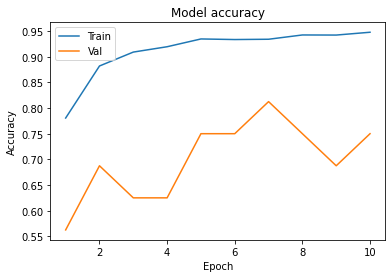

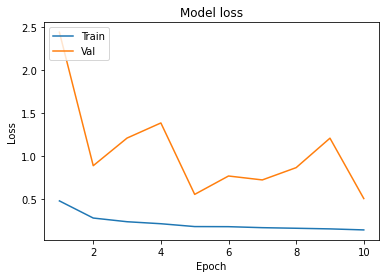

In [74]:
 plot_learningCurve (history, 10)

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 35s 900ms/step - loss: 0.3186 - accuracy: 0.9071
The testing accuracy is : 90.70512652397156 %


### Bounce 

In [12]:
def create_model(Learning_rate,activation): 
   cnn = Sequential()
   cnn.add(Conv2D(32, (3, 3), activation="relu",strides=1,padding='same', input_shape=(img_width, img_height, 1)))
   cnn.add(MaxPooling2D(pool_size = (2, 2)))

   cnn.add(Conv2D(32, (3, 3), activation="relu",strides=(2,2),padding='same', input_shape=(img_width, img_height, 1)))
   cnn.add(MaxPooling2D(pool_size = (2, 2)))

   cnn.add(Conv2D(32, (3, 3), activation="relu",strides=1,padding='same', input_shape=(img_width, img_height, 1)))
   cnn.add(MaxPooling2D(pool_size = (2, 2)))

   cnn.add(Conv2D(64, (3, 3), activation="relu",strides=(2,2),padding='same', input_shape=(img_width, img_height, 1)))
   cnn.add(MaxPooling2D(pool_size = (2, 2)))

   cnn.add(Conv2D(64, (3, 3), activation="relu",strides=1,padding='same', input_shape=(img_width, img_height, 1)))
   cnn.add(MaxPooling2D(pool_size = (2, 2)))

   cnn.add(Conv2D(64, (3, 3), activation="relu",strides=(2,2),padding='same' ,input_shape=(img_width, img_height, 1)))
   cnn.add(MaxPooling2D(pool_size = (2, 2)))


# cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
# cnn.add(MaxPooling2D(pool_size = (2, 2)))

   cnn.add(Flatten())
   cnn.add(Dense(128,activation = 'relu'))
   cnn.add(Dense(64,activation = 'relu'))
# cnn.add(Dense(activation = 'sigmoid', units = 1))
   cnn.add(Dense(1, activation = 'sigmoid'))
   cnn.compile(optimizer= Adam(lr=Learning_rate), loss = "binary_crossentropy", metrics = ["accuracy"])
   cnn.summary()

   return cnn

In [16]:
pip install tensorflow scikeras scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from sklearn.model_selection import train_test_split
import os

# Get all the images in the NORMAL folder
normal_images = [os.path.join("/content/drive/MyDrive/train/NORMAL", image) for image in os.listdir("/content/drive/MyDrive/train/NORMAL")]

# Get all the images in the PNEUMONIA folder
pneumonia_images = [os.path.join("/content/drive/MyDrive/train/PNEUMONIA", image) for image in os.listdir("/content/drive/MyDrive/train/PNEUMONIA")]

# Combine the images from both folders
images = normal_images + pneumonia_images

# Create the labels for the images (0 for NORMAL, 1 for PNEUMONIA)
labels = [0] * len(normal_images) + [1] * len(pneumonia_images)

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)

In [20]:
model3 = KerasClassifier(build_fn=create_model,batch_size =100,epochs=10)


<ipython-input-20-fd0092798b88>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model3 = KerasClassifier(build_fn=create_model,batch_size =100,epochs=10)


In [21]:
X_train = np.array(X_train)
y_train = np.array(y_train )

In [ ]:
# history = cnn.fit(train, epochs= 5, validation_data= val, verbose=1)

In [22]:
Learning_rate = [0.01,0.001,0.0001,0.0001]
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(Learning_rate=Learning_rate,activation=activation)
grid = GridSearchCV(estimator=model3, param_grid=param_grid, n_jobs=-1, cv=3,scoring="accuracy")
grid_result = grid.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
96 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/usr/local

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 500, 500, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 250, 250, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10


ValueError: ignored